In [134]:
from __init__ import *
from raw_quote import utils
% matplotlib inline

In [161]:
key = 'value_importance'
mindate = '2017-01-12'
files = [f for f in os.listdir('results') if (key in f) and ('.pkl' in f)]
read_tables = []
for f in files:
    try:
        df = pd.read_pickle('results/' + f)
        df = df[df['dt'] > pd.Timestamp(mindate)]
        df['epochs'] = df['loss'].apply(lambda x: len(x))
        df = df[df['epochs'] > 5]
        if df.shape[0] == 0:
            continue
        df['objective'] = 'regr' if ('regr' in f) else 'class'
        if 'returns' not in df.columns:
            df['returns'] = ('ret' in f)
        elif 'both' in f:
            df = df[df['returns']] ###### screwed up classification loss in 'both'
        if 'full_shift' not in df.columns:
            df['full_shift'] = ('fs' in f)
        df['NeX'] = ('NeX' in f)
        if 'batch_size' not in df.columns:
            df['batch_size'] = 64
        if 'channels' not in df.columns:
            df['channels'] = 1
        else:
            df.loc[np.isnan(df['channels']), 'channels'] = 1
        if 'benchmark' in f:
            df['model'] = 'lr'
        elif '_cnn_' in f:
            df['model'] = 'cnn'
        elif '_gru_' in f:
            df['model'] = 'gru'
        elif '_lstm_' in f:
            df['model'] = 'lstm'
        elif 'value_importance3' in f:
            df['model'] = 'so'
        else:
            df['model'] = 'so'
        keys, funcs, names = [], [], []
        df['best_mse'] = np.NaN
        df['best_acc'] = np.NaN
        if 'class' in f:
            if 'val_main_output_acc' in df.columns:
                keys.append('val_main_output_acc')
                funcs.append(np.nanmax)
                names.append('best_acc')
            elif 'val_acc' in df.columns:
                keys.append('val_acc')
                funcs.append(np.nanmax)
                names.append('best_acc')
        if 'regr' in f:
            if 'val_main_output_loss' in df.columns:
                keys.append('val_main_output_loss')
                funcs.append(np.nanmin)
                names.append('best_mse')
            elif 'val_loss' in df.columns:
                keys.append('val_loss')
                funcs.append(np.nanmin)        
                names.append('best_mse')
        for k, func, n in zip(keys, funcs, names):
            df[n] = df[k].apply(lambda x: func(x))
        df['file'] = ''.join(f.split(key))
        read_tables.append(df.copy())
    except Exception as e:
        print(e)
all_results = pd.concat(read_tables)  
all_results.reset_index(inplace=True)
                
def get_pivot(setting, df, valcols=[]):
    if setting['objective'] == 'class':
        best = 'best_acc'
        func = max
    else:
        best = 'best_mse'
        func = min
    df0 = df.copy()
    for k, v in setting.items():
        df0 = df0[df0[k] == v]
    df0 = df0[df0.groupby(['data', 'model'])[best].transform(func) == df0[best]]
    pivs = [df0.pivot(index='data', columns='model', values=best)]
    for col in valcols:
        piv = df0.pivot(index='data', columns='model', values=col)
        piv.rename(columns=dict([(c, col[:3] + '_' + c) for c in piv.columns]), inplace=True)
        pivs.append(piv.copy())
    return df0, pd.concat(pivs, axis=1)

In [162]:
pivots = []
for obj in ['regr', 'class']:
    setting = dict(
        NeX = False,
        objective = obj,
        returns = True,
        batch_size = 8,
    )

    df0, pivot = get_pivot(setting, all_results, [])
    pivots.append(pivot.rename(columns=dict([(c, c + '_' + obj) for c in pivot.columns if c not in ['model', 'data']])))
pivs = pd.concat(pivots, axis=1)

In [167]:
sources_to_plot = ['BMLM', 'GSET', 'SCDS', 'BMLE', 'JPGP', 'GSMX', 'MSTT', 'CSDE', 'CSEO', 
                   'JCTT', 'MBNP', 'MSTX', 'Citi', 'HSCX', 'SocG']
pivs.loc[sources_to_plot]

model,cnn_regr,lr_regr,so_regr,cnn_class,lr_class,so_class
data,,,,,,
BMLM,0.009551,0.011769,0.008941,0.948120,0.896334,0.956496
GSET,0.239446,0.268212,0.252570,0.547251,0.561593,0.590421
SCDS,0.088186,0.124367,0.084814,0.500597,0.594311,0.622685
BMLE,0.369369,0.358594,0.337039,0.608772,0.645356,0.662801
JPGP,0.102793,0.177789,0.097481,0.594001,0.602568,0.600802
GSMX,0.010123,0.010765,0.007669,0.978976,0.923420,0.981100
MSTT,0.265488,0.249157,0.238991,NaN,0.631777,0.655069
CSDE,0.143828,0.116400,0.102873,NaN,0.877577,0.946664
CSEO,0.134683,0.100606,0.092232,NaN,0.879821,0.945900


C:\Anaconda3\envs\tf35\lib\site-packages\ipykernel\__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


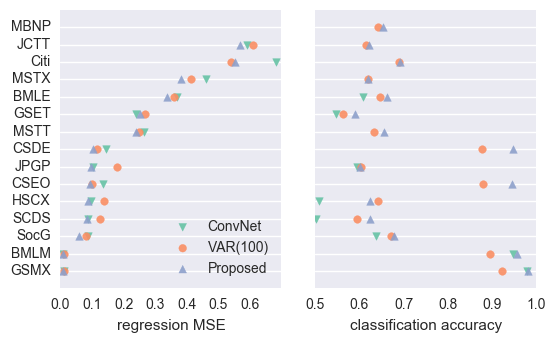

In [173]:
fig, axes = plt.subplots(1, 2, figsize=(5.5,3.2), sharey=True)
fig.tight_layout()
pivs = pivs.loc[sources_to_plot]

ind = 1
pivs.sort_values('so_class' if (ind < 0) else 'so_regr', inplace=True, ascending=True)
label_dict = {'lr': 'VAR(100)', 'so': 'Proposed', 'cnn': 'ConvNet'}

for ax, obj, xlim, title in zip(axes, ['regr', 'class'][::ind], [(0,.7), (.5, 1)][::ind], 
                                ['regression MSE', 'classification accuracy'][::ind]):
    pivot0 = pivs[[c for c in pivs.columns if obj in c]].copy()
    # pivot0 = pivot0[np.isnan(pivot0).sum(axis=1)==0].copy()
    pivot0.reset_index(drop=False, inplace=True)

    colors = sns.color_palette("Set2", 8)[:3]
    for c, color, marker in zip(pivot0.columns[1:], colors, ['v', 'o', '^']):
        ax.scatter(pivot0[c], pivot0.index, label=label_dict[c.split('_')[0]], color=color, s=30, alpha=.9, marker=marker)
#     
    ax.set_yticks(pivot0.index)
    ax.set_yticklabels(pivot0['data'])
    ax.set_xlim(xlim)
    ax.xaxis.grid(False)
    ax.set_xlabel(title)
axes[(1 - ind)/2].legend(loc=4)
# axes[(1 - ind)/2].set_xscale('log')
# axes[0].set_xlim(.01,10)
fig.subplots_adjust(bottom=0.15, left=.11, top=1.02,right=.975)
fig.savefig('plots/results.png')

In [41]:
df1 = df0[df0['model'] == 'so'].copy()
df1 = df1[df1['best_mse'] == df1.groupby('data')['best_mse'].transform(min)]

In [63]:
from raw_quote import utils, ret_utils, utils2
from keras.models import load_model

sources = ['ABNP', 'BMLE', 'BMLM', 'BXCY','Barc','CCGB','CCGC','CCIB','CGCX','CMAr','CSDE','CSEO','Citi','Deut',
           'EBNP','GSET','GSMX','GSOL','HSCX','JCTT','JPGP','MBNP','MSTT','MSTX','SCDS','SGMI','SocG','UBCD']
cols = sources + ['dir', 'price', 'time'] + ['imps', 'shifts']

def get_layer_no(nn, name):
    for n, l in enumerate(nn.layers):
        if l.name == name:
            print(('layer no for ', l.name, name, n))
            return n
    return None

def get_info(source_id, df, sources=sources, cols=cols, steps=None):
    with tf.Session() as sess:
        nn = load_model(df['hdf5'][source_id])
        source = df.loc[source_id, 'data']

        X, y, n_train, n_all, div, Xmeans, Xstds = utils2.getXy2('preprocessed/raw_%s.pickle' % source, return_stats=True)  
        df.loc[source_id, 'dim'] = X.shape[0]
        if steps is None:
            steps = n_train

        imp = Model(input=[nn.layers[get_layer_no(nn, 'importance_input')].input], 
                    output=[nn.layers[get_layer_no(nn, 'softmax')].output]) # softmax
        shift_input = 'shift_input'
        shift_no = get_layer_no(nn, 'shift_input')
        if shift_no is None:
            shift_no = get_layer_no(nn, 'importance_input')
            shift_input = 'importance_input'
        shift = Model(input=[nn.layers[shift_no].input], 
                      output=[nn.layers[get_layer_no(nn, 'shiftreshape')].output]) #shiftreshape
        length = 100
        gen = utils2.vgen(X, y, 0, n_train, length, utils2.VI_ret_regr, validator=utils2.validator0)

        imps = []
        shifts = []
        info = []
        for i in range(steps):
            if np.random.rand() > .1:
                continue
            xx, _ = next(gen)
            info.append(xx['importance_input'][:, :, :])
            imps.append(imp.predict_on_batch(xx['importance_input']))
            shifts.append(shift.predict_on_batch(xx[shift_input]))
            if i%5000 == 0:
                print('steps %d/%d' % (i, steps))
        
        dim = info[0].shape[0]
        
        info2 = [np.concatenate([inf, i.reshape(dim, 100, 1), sh.reshape(dim, 100, 1)], axis=2) for inf, i, sh in zip(info, imps, shifts)]
        info2 = np.concatenate(np.concatenate(info2, axis=1), axis=0)
        info2[:, :28] = (info2[:, :28] > 0)

        info3 = pd.DataFrame(info2, columns=cols)
        info3['source'] = np.nan
        for s in sources:
            info3.loc[info3[s] > 0, 'source'] = s    
        return info3

In [64]:
df1['dim'] = np.nan
df1['avg_imp'] = np.nan
for idx in df1.index:
    try:
        info = get_info(idx, df1)
        print(df1['data'][idx])
        high_imp = info.groupby('source')['imps'].mean().sort_values(ascending=False)
        df1.loc[idx, 'avg_imp'] = [high_imp.to_dict()]
    except Exception as e:
        print(e)

KeyboardInterrupt: 

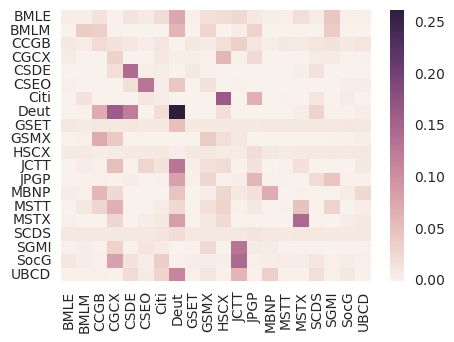

In [54]:
cross_imp = pd.DataFrame([dict(list(y[0].items()) + [('data', x)]) for x, y in zip(df1['data'], df1['avg_imp'])])
cross_imp.set_index('data', drop=True, inplace=True)
# sources_to_plot = [x for x in list(cross_imp.index) if x not in ['CCIB', 'EBNP']]
sources_to_plot = [s for s in sources if s not in ['ABNP', 'Barc', 'CCGC', 'CCIB', 'CMAr', 'EBNP', 'BXCY', 'GSOL']]
fig, ax = plt.subplots(1, figsize=(5,3.5))
sns.heatmap(cross_imp.loc[sources_to_plot, sources_to_plot], ax=ax)
ax.set_ylabel('')
# ax.invert_yaxis()
fig.savefig('plots\cross_significance1.png')

In [327]:
pd.DataFrame([dict(list(y[0].items()) + [('data', x)]) for x, y in zip(df1['data'], df1['avg_imp'])])

KeyError: 'avg_imp'

In [122]:
df0['file']

67     keras_1benchmark_class_ret.pkl
68     keras_1benchmark_class_ret.pkl
69     keras_1benchmark_class_ret.pkl
70     keras_1benchmark_class_ret.pkl
71     keras_1benchmark_class_ret.pkl
72     keras_1benchmark_class_ret.pkl
73     keras_1benchmark_class_ret.pkl
74     keras_1benchmark_class_ret.pkl
75     keras_1benchmark_class_ret.pkl
76     keras_1benchmark_class_ret.pkl
77     keras_1benchmark_class_ret.pkl
78     keras_1benchmark_class_ret.pkl
79     keras_1benchmark_class_ret.pkl
80     keras_1benchmark_class_ret.pkl
81     keras_1benchmark_class_ret.pkl
82     keras_1benchmark_class_ret.pkl
83     keras_1benchmark_class_ret.pkl
84     keras_1benchmark_class_ret.pkl
85     keras_1benchmark_class_ret.pkl
86     keras_1benchmark_class_ret.pkl
87     keras_1benchmark_class_ret.pkl
88     keras_1benchmark_class_ret.pkl
89     keras_1benchmark_class_ret.pkl
90     keras_1benchmark_class_ret.pkl
91     keras_1benchmark_class_ret.pkl
193             keras_3_class_ret.pkl
195         

In [22]:
get_layer_no(nn, 'importance_input')

NameError: name 'nn' is not defined

In [174]:
df.columns

Index(['act', 'architecture', 'aux_weight', 'batchnorm', 'data', 'date',
       'datetime', 'div', 'dt', 'hdf5', 'initialization', 'layer_size',
       'layers_no', 'length', 'loss', 'main_output_loss', 'norm', 'patience',
       'training_time', 'val_loss', 'val_main_output_loss',
       'val_value_output_loss', 'value_output_loss', 'verbose', 'epochs',
       'objective', 'returns', 'full_shift', 'NeX', 'batch_size', 'channels',
       'model', 'best_mse', 'best_acc', 'file'],
      dtype='object')